In [1]:
import os 
import cv2
import face_recognition as fr

In [2]:
import os 
import cv2
import face_recognition

name = input('نام شخص تایید شده رو وارد کن: ')

user_folder = os.path.join('user' , name)
os.makedirs(user_folder,exist_ok=True)

cap = cv2.VideoCapture(0)

ret , frame = cap.read()

print(ret)

True


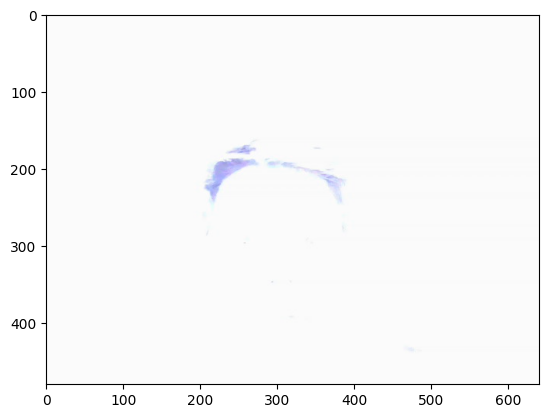

In [3]:
from matplotlib import pyplot as plt

plt.imshow(frame)

In [4]:
if ret == True:
    img = cv2.cvtColor(frame ,cv2.COLOR_BGR2RGB)
    faces = fr.face_locations(img)
    if len(faces) == 1:
        photo_path = os.path.join(user_folder,f'{name}.jpg')
        cv2.imwrite(photo_path,frame)
        print(f'ذخیره شد در آدرس{photo_path}')
    else:
        print('هیچ صورتی در تصویر پیدا نشد')
else:
    print('خطا در تصویر برداری')
cap.release()
cv2.destroyAllWindows()
print(faces)

هیچ صورتی در تصویر پیدا نشد
[]


In [ ]:
#problem
import time
import numpy as np
from datetime import datetime
from tensorflow.keras.models import load_model

user_path = 'user'

user_name = os.listdir(user_path)[0]
user_folder= os.path.join(user_path,user_name)
unknown_folder = os.path.join(user_folder,'unknown_faces')
os.makedirs(unknown_folder,exist_ok=True)

user_image_path = os.path.join(user_folder , f'{user_name}.jpg')

if not os.path.exists(user_image_path):
    print('تصویر ثبت نشده و کاربر یافت نشده')

user_image = fr.load_image_file(user_image_path)

user_encoding = fr.face_encodings(user_image)[0]

#emotion mode loading

emotion_model = load_model('emotion_model.h5',compile=False)

emotion_lable = ['عصبانی','متنفر', 'ناراحت','ترسیده','شاد','متعجب','خنثی']

cap = cv2.VideoCapture(0)

user_detect = False
user_detect_start = None
user_activation_time = 3

unknown_saved = False
highest_saved = False

highest_similarity = 0

user_emotion = {}

for e in emotion_lable:
    user_emotion[e]=0

user_motion = 0

last_posion = None
start_delay = 5

session_start = time.time()

print('برای خروج q رو بزن')

while True :
    ret,frame = cap.read()

    if ret == False:
        break
    else:
        rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

        locations = fr.face_locations(rgb)
        encoding = fr.face_encodings(rgb , locations)

        for (top , right , bottom , left), face_enc in zip(locations,encoding):
            dist = fr.face_distance([user_encoding],face_enc)[0]
            similarity = (1 - dist) * 100


            if similarity> highest_similarity:
                highest_similarity = similarity

            cv2.rectangle(frame,(left , top ),(right,bottom),(0,0,255),2)

            if similarity >= 60 : 
                if not user_detect :
                    if user_detect_start is None:
                        user_detect_start = time.time()
                    elif time.time() - user_detect_start>=user_activation_time:
                        user_detect = True
                        start_time = time.time()
                        print('کاربر تایید شد و سیستم فعال شد')
            else:
                roi = cv2.cvtColor(frame[top:bottom,left:right],cv2.COLOR_BGR2GRAY)
                roi = cv2.resize(roi,(64,64)) / 255.0
                roi = roi.reshape(1,64,64,1)
                emo = emotion_lable[np.argmax(emotion_model.predict(roi, verbose=0))]
                user_emotion[emo]+=1

                center = ((left + right) // 2, (top + bottom) // 2)

                if last_posion == True:
                    user_motion += np.linalg.norm(np.array(center) - np.array(last_posion))
                    last_posion = center

                    cv2.putText(frame,f'{user_name}: {similarity}',(left , top - 10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),2)
                elif similarity < 70 and user_detect and not unknown_saved and (time.time() - session_start >= start_delay):
                    roi_gray = cv2.cvtColor(rgb[top:bottom,left:right],cv2.COLOR_BGR2GRAY)
                    emo = emotion_lable[np.argmax(emotion_model.predict(roi.reshape(1,64,64,1), verbose=0))]

                    center = ((left + right) // 2, (top + bottom) // 2)

                    if last_posion == True:
                        user_motion += np.linalg.norm(np.array(center) - np.array(last_posion))
                    last_posion = center
                    
                    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
                    

                    x = os.path.join(unknown_folder,f'unknown_{ts}.jpg')

                    cv2.imwrite(x, frame[top:bottom,left:right])
                    rep = f'unknown {ts} emotion: {emo} similarity: {similarity}% \n'

                    with open(os.path.join(user_folder,'unknown_report.txt'),'a',encoding='utf-8') as f:
                        f.write(rep)

                    unknown_saved = True
            cv2.imshow('دوربین',frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()

    if user_detect and start_time:
        endt = time.time()
        dur = endt - start_time

        dom = max(user_emotion , key=user_emotion.get)

        out = (
            f'{user_name}در {datetime.now().strftime("%Y/%m/%d - %H:%M:%S")} \n'
            f'مدت حضور: {dur} \n'
            f'احساس قالب : {dom} \n'
            f'بیشترین شباهت: {highest_similarity}% \n'
            f'حرکت کاربر: {user_motion} \n'

        )
        with open(os.path.join(user_folder,'user_report.txt'),'a',encoding='utf-8') as f:
            f.write(out)
        print('گزارش کاربر ذخیره شد')
print(f'بیشترین شباهت: {highest_similarity}%')




برای خروج q رو بزن
بیشترین شباهت: 65.43648604961847%


In [ ]:
import os
import cv2
import face_recognition
from datetime import datetime
from tensorflow.keras.models import load_model

name = input(" نام خود را وارد کنید: ")
user_folder = os.path.join("users", name)
os.makedirs(user_folder, exist_ok=True)

cap = cv2.VideoCapture(0)
ret, frame = cap.read()


if ret == True:
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_recognition.face_locations(rgb_frame)
    if len(faces) >= 1:
        photo_path = os.path.join(user_folder, f"{name}.jpg")
        cv2.imwrite(photo_path, frame)
        print(f" عکس در {photo_path} ذخیره شد.")
    else:
        print(" مطمئن شو فقط یک صورت واضح در تصویر وجود دارد.")
else:
    print(" عکس‌برداری ناموفق بود.")

cap.release()
cv2.destroyAllWindows()
import numpy as np
import time
from datetime import datetime
from tensorflow.keras.models import load_model

users_path = "users"
user_name = os.listdir(users_path)[0]
user_folder = os.path.join(users_path, user_name)
unknown_folder = os.path.join(user_folder, "unknown_faces")
os.makedirs(unknown_folder, exist_ok=True)

user_image_path = os.path.join(user_folder, f"{user_name}.jpg")
if not os.path.exists(user_image_path):
    print("تصویر کاربر یافت نشد.")
    exit()

user_image = face_recognition.load_image_file(user_image_path)
user_encoding = face_recognition.face_encodings(user_image)[0]

emotion_model = load_model('emotion_model.h5', compile=False)
emotion_labels = ['عصبانی', 'متنفر', 'ترسیده', 'شاد', 'ناراحت', 'متعجب', 'خنثی']

cap = cv2.VideoCapture(0)

user_detected = False
user_detect_start = None
user_activation_time = 3
unknown_saved = False
highest_similarity = 0

user_emotions = {}
for e in emotion_labels:
    user_emotions[e] = 0

user_motion = 0
last_position = None
start_time = None

start_delay = 5
session_start = time.time()

print("برنامه اجرا شد. کلید 'q' برای خروج.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    locations = face_recognition.face_locations(rgb)
    encodings = face_recognition.face_encodings(rgb, locations)

    for (top, right, bottom, left), face_enc in zip(locations, encodings):
        dist = face_recognition.face_distance([user_encoding], face_enc)[0]
        similarity = (1 - dist) * 100
        if similarity > highest_similarity:
            highest_similarity = similarity

        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 255), 2)

        if similarity >= 70:
            if not user_detected:
                if user_detect_start is None:
                    user_detect_start = time.time()
                elif time.time() - user_detect_start >= user_activation_time:
                    user_detected = True
                    start_time = time.time()
                    print("کاربر تأیید شد و سیستم فعال شد.")
            else:
                roi = cv2.cvtColor(rgb[top:bottom, left:right], cv2.COLOR_RGB2GRAY)
                roi = cv2.resize(roi, (64, 64)) / 255.0
                roi = roi.reshape(1, 64, 64, 1)
                emo = emotion_labels[np.argmax(emotion_model.predict(roi, verbose=0))]
                user_emotions[emo] += 1

                center = ((left + right) // 2, (top + bottom) // 2)
                if last_position:
                    user_motion += np.linalg.norm(np.array(center) - np.array(last_position))
                last_position = center

            cv2.putText(
                frame,
                f"{user_name}: {similarity:.1f}%",
                (left, top - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                2
            )

        elif similarity < 60 and user_detected and not unknown_saved and (time.time() - session_start > start_delay):
            roi_gray = cv2.cvtColor(rgb[top:bottom, left:right], cv2.COLOR_RGB2GRAY)
            roi_resized = cv2.resize(roi_gray, (64, 64)) / 255.0
            emo = emotion_labels[np.argmax(emotion_model.predict(roi_resized.reshape(1, 64, 64, 1), verbose=0))]

            center = ((left + right) // 2, (top + bottom) // 2)
            if last_position:
                user_motion += np.linalg.norm(np.array(center) - np.array(last_position))
            last_position = center

            ts = datetime.now().strftime('%Y%m%d_%H%M%S')
            p = os.path.join(unknown_folder, f"unknown_{ts}.jpg")
            cv2.imwrite(p, frame[top:bottom, left:right])

            rep = f"ناشناس {ts} شباهت:{similarity:.1f}% احساس:{emo} تحرک:{user_motion:.1f}\n"
            with open(os.path.join(user_folder, "unknown_report.txt"), "a", encoding="utf-8") as f:
                f.write(rep)
            unknown_saved = True

    cv2.imshow("دوربین", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

if user_detected and start_time:
    endt = time.time()
    dur = endt - start_time
    dom = max(user_emotions, key=user_emotions.get)
    out = (
        f"{user_name} در {datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}\n"
        f"مدت حضور: {dur:.1f} ثانیه\n"
        f"احساس غالب: {dom}\n"
        f"تحرک: {user_motion:.1f}\n"
        f"بیشترین شباهت: {highest_similarity:.1f}%\n\n"
    )
    with open(os.path.join(user_folder, "verified_user_report.txt"), "a", encoding="utf-8") as f:
        f.write(out)
    print("گزارش کاربر ذخیره شد.")

print(f"بیشترین شباهت: {highest_similarity:.1f}%")



In [1]:
#full
import os
import cv2
import face_recognition
from datetime import datetime
from tensorflow.keras.models import load_model

name = input(" نام خود را وارد کنید: ")
user_folder = os.path.join("users", name)
os.makedirs(user_folder, exist_ok=True)

cap = cv2.VideoCapture(0)
ret, frame = cap.read()


if ret == True:
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_recognition.face_locations(rgb_frame)
    if len(faces) >= 1:
        photo_path = os.path.join(user_folder, f"{name}.jpg")
        cv2.imwrite(photo_path, frame)
        print(f" عکس در {photo_path} ذخیره شد.")
    else:
        print(" مطمئن شو فقط یک صورت واضح در تصویر وجود دارد.")
else:
    print(" عکس‌برداری ناموفق بود.")

cap.release()
cv2.destroyAllWindows()


 عکس در users\sajadd\sajadd.jpg ذخیره شد.


In [2]:
#full



import numpy as np
import time
from datetime import datetime
from tensorflow.keras.models import load_model

users_path = "users"
user_name = os.listdir(users_path)[0]
user_folder = os.path.join(users_path, user_name)
unknown_folder = os.path.join(user_folder, "unknown_faces")
os.makedirs(unknown_folder, exist_ok=True)

user_image_path = os.path.join(user_folder, f"{user_name}.jpg")
if not os.path.exists(user_image_path):
    print("تصویر کاربر یافت نشد.")
    exit()

user_image = face_recognition.load_image_file(user_image_path)
user_encoding = face_recognition.face_encodings(user_image)[0]

emotion_model = load_model('emotion_model.h5', compile=False)
emotion_labels = ['عصبانی', 'متنفر', 'ترسیده', 'شاد', 'ناراحت', 'متعجب', 'خنثی']

cap = cv2.VideoCapture(0)

user_detected = False
user_detect_start = None
user_activation_time = 3
unknown_saved = False
highest_similarity = 0

user_emotions = {}
for e in emotion_labels:
    user_emotions[e] = 0

user_motion = 0
last_position = None
start_time = None

start_delay = 5
session_start = time.time()

print("برنامه اجرا شد. کلید 'q' برای خروج.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    locations = face_recognition.face_locations(rgb)
    encodings = face_recognition.face_encodings(rgb, locations)

    for (top, right, bottom, left), face_enc in zip(locations, encodings):
        dist = face_recognition.face_distance([user_encoding], face_enc)[0]
        similarity = (1 - dist) * 100
        if similarity > highest_similarity:
            highest_similarity = similarity

        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 255), 2)

        if similarity >= 70:
            if not user_detected:
                if user_detect_start is None:
                    user_detect_start = time.time()
                elif time.time() - user_detect_start >= user_activation_time:
                    user_detected = True
                    start_time = time.time()
                    print("کاربر تأیید شد و سیستم فعال شد.")
            else:
                roi = cv2.cvtColor(rgb[top:bottom, left:right], cv2.COLOR_RGB2GRAY)
                roi = cv2.resize(roi, (64, 64)) / 255.0
                roi = roi.reshape(1, 64, 64, 1)
                emo = emotion_labels[np.argmax(emotion_model.predict(roi, verbose=0))]
                user_emotions[emo] += 1

                center = ((left + right) // 2, (top + bottom) // 2)
                if last_position:
                    user_motion += np.linalg.norm(np.array(center) - np.array(last_position))
                last_position = center

            cv2.putText(
                frame,
                f"{user_name}: {similarity:.1f}%",
                (left, top - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                2
            )

        elif similarity < 60 and user_detected and not unknown_saved and (time.time() - session_start > start_delay):
            roi_gray = cv2.cvtColor(rgb[top:bottom, left:right], cv2.COLOR_RGB2GRAY)
            roi_resized = cv2.resize(roi_gray, (64, 64)) / 255.0
            emo = emotion_labels[np.argmax(emotion_model.predict(roi_resized.reshape(1, 64, 64, 1), verbose=0))]

            center = ((left + right) // 2, (top + bottom) // 2)
            if last_position:
                user_motion += np.linalg.norm(np.array(center) - np.array(last_position))
            last_position = center

            ts = datetime.now().strftime('%Y%m%d_%H%M%S')
            p = os.path.join(unknown_folder, f"unknown_{ts}.jpg")
            cv2.imwrite(p, frame[top:bottom, left:right])

            rep = f"ناشناس {ts} شباهت:{similarity:.1f}% احساس:{emo} تحرک:{user_motion:.1f}\n"
            with open(os.path.join(user_folder, "unknown_report.txt"), "a", encoding="utf-8") as f:
                f.write(rep)
            unknown_saved = True

    cv2.imshow("دوربین", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

if user_detected and start_time:
    endt = time.time()
    dur = endt - start_time
    dom = max(user_emotions, key=user_emotions.get)
    out = (
        f"{user_name} در {datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}\n"
        f"مدت حضور: {dur:.1f} ثانیه\n"  
        f"احساس غالب: {dom}\n"
        f"تحرک: {user_motion:.1f}\n"
        f"بیشترین شباهت: {highest_similarity:.1f}%\n\n"
    )
    with open(os.path.join(user_folder, "verified_user_report.txt"), "a", encoding="utf-8") as f:
        f.write(out)
    print("گزارش کاربر ذخیره شد.")

print(f"بیشترین شباهت: {highest_similarity:.1f}%")


برنامه اجرا شد. کلید 'q' برای خروج.
کاربر تأیید شد و سیستم فعال شد.
گزارش کاربر ذخیره شد.
بیشترین شباهت: 73.0%
